In [1]:
import generate_datasets as ds
from MNIST_functions import *
import numpy as np
import pandas as pd
import csv
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
#Generate permuted and rotated tasks 
num_tasks_permute= 10
num_tasks_rotate = 10
permuted_train_loaders, permuted_test_loaders, rotated_train_loaders, rotated_test_loaders = ds.load_datasets(num_tasks_permute=10, num_tasks_rotate=10)

In [4]:
#Run experiment 2A for permutated MNIST on 3 tasks
num_tasks_permuted_2A = 3
epoch_accuracies_SGD_permutated, epoch_accuracies_EWC_permutated, epoch_accuracies_L2_permutated = run_experiment_2A( permuted_train_loaders[0:num_tasks_permuted_2A], permuted_test_loaders[0:num_tasks_permuted_2A], num_tasks=num_tasks_permuted_2A)

Learning rate: 0.001, Dropout input: 0.0, Dropout hidden: 0.0, Early stopping: False, Num hidden layers: 2, Width hidden layers: 400, Lambda 10000, Epochs: 20
Epoch 1/20, Accuracy on test set 0: 0.9391
Epoch 2/20, Accuracy on test set 0: 0.9521
Epoch 3/20, Accuracy on test set 0: 0.9609
Epoch 4/20, Accuracy on test set 0: 0.9645
Epoch 5/20, Accuracy on test set 0: 0.9660
Epoch 6/20, Accuracy on test set 0: 0.9688
Epoch 7/20, Accuracy on test set 0: 0.9692
Epoch 8/20, Accuracy on test set 0: 0.9696
Epoch 9/20, Accuracy on test set 0: 0.9708
Epoch 10/20, Accuracy on test set 0: 0.9703
Epoch 11/20, Accuracy on test set 0: 0.9718
Epoch 12/20, Accuracy on test set 0: 0.9725
Epoch 13/20, Accuracy on test set 0: 0.9728
Epoch 14/20, Accuracy on test set 0: 0.9719
Epoch 15/20, Accuracy on test set 0: 0.9729
Epoch 16/20, Accuracy on test set 0: 0.9725
Epoch 17/20, Accuracy on test set 0: 0.9732
Epoch 18/20, Accuracy on test set 0: 0.9733
Epoch 19/20, Accuracy on test set 0: 0.9735
Epoch 20/20, A

In [4]:
def flatten_for_csv(epoch_accuracies_SGD, epoch_accuracies_EWC, epoch_accuracies_L2):
    rows = []
    max_epochs = 20 
    
    for train_task in epoch_accuracies_SGD:
        for eval_task in epoch_accuracies_SGD[train_task]:
            for epoch in range(max_epochs):
                row = {
                    'Epoch': epoch + 1,  # Epochs start at 1, not 0
                    'Train_Task': train_task,
                    'Eval_Task': eval_task,
                    'SGD_Accuracy': epoch_accuracies_SGD[train_task][eval_task][epoch],
                    'EWC_Accuracy': epoch_accuracies_EWC[train_task][eval_task][epoch],
                    'L2_Accuracy': epoch_accuracies_L2[train_task][eval_task][epoch],
                }
                rows.append(row)
    
    return rows

def plot_experiment_2A(epoch_accuracies_SGD, epoch_accuracies_EWC, epoch_accuracies_L2):
    def flatten(lst):
        return [item for sublist in lst for item in sublist]
    
    sgd_data = []
    ewc_data = []
    l2_data = []
    time_data = []

    for task_index in range(len(epoch_accuracies_SGD)):
        sgd_task = [epoch_accuracies_SGD[i][task_index] for i in range(len(epoch_accuracies_SGD[task_index]))]
        ewc_task = [epoch_accuracies_EWC[i][task_index] for i in range(len(epoch_accuracies_EWC[task_index]))]
        l2_task = [epoch_accuracies_L2[i][task_index] for i in range(len(epoch_accuracies_L2[task_index]))]
        
        sgd_flat = flatten(sgd_task)
        ewc_flat = flatten(ewc_task)
        l2_flat = flatten(l2_task)

        sgd_data.append(sgd_flat)
        ewc_data.append(ewc_flat)
        l2_data.append(l2_flat)

        # Create time data for the current task
        time_data.append(np.arange(len(sgd_flat)))
        
    figure_height = len(sgd_data)  # Adjust the multiplier to control the spacing
    fig, axes = plt.subplots(len(sgd_data), 1, figsize=(10, figure_height), sharex=True)
    colors = {'ewc': 'red', 'l2': 'green', 'sgd': 'blue'}
    max_len = len(sgd_data[0])

    for task_index in range(len(sgd_data)):
        time = time_data[0]
        
        # Pad with NaNs if necessary
        def pad_with_nans(original, max_len):
            return [np.nan] * (max_len - len(original)) + original

        sgd_padded = pad_with_nans(sgd_data[task_index], max_len)
        ewc_padded = pad_with_nans(ewc_data[task_index], max_len)
        l2_padded = pad_with_nans(l2_data[task_index], max_len)

        # Plot each task
        axes[task_index].plot(time, sgd_padded, label="SGD", color=colors['sgd'], alpha=0.8)
        axes[task_index].plot(time, ewc_padded, label="EWC", color=colors['ewc'], alpha=0.8)
        axes[task_index].plot(time, l2_padded, label="L2", color=colors['l2'], alpha=0.8)
        
        for i in range(19, max_len, 20):
            axes[task_index].axvline(x=i, color='gray', linestyle='--', linewidth=1)
        
        axes[task_index].set_ylabel(f"Task {chr(65 + task_index)}") 
        axes[task_index].legend(loc="lower left")
        axes[task_index].set_xticks([])
        if task_index < len(sgd_data) - 1:
            axes[task_index].set_xticklabels([])

    axes[-1].set_xlabel("Training time")

    plt.tight_layout()
plt.show()


In [6]:
# Save 2A permutated results
flattened_data_permutated = flatten_for_csv(epoch_accuracies_SGD_permutated, epoch_accuracies_EWC_permutated, epoch_accuracies_L2_permutated)

with open('experiment2A_results_permutated_10k.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['Epoch', 'Train_Task', 'Eval_Task', 'SGD_Accuracy', 'EWC_Accuracy', 'L2_Accuracy'])
    writer.writeheader() 
    writer.writerows(flattened_data_permutated)  

print("Data saved to experiment2A_results_permutated.csv")

Data saved to experiment2A_results_permutated.csv


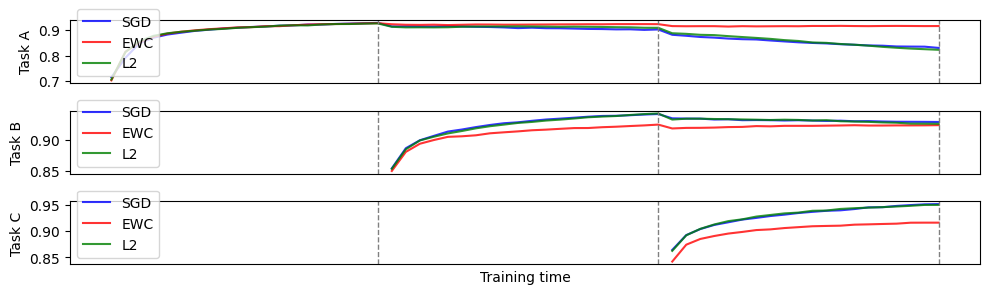

In [14]:
#Plot results for experiment 2A on permutated MNIST
file_path = "experiment2A_results_permutated.csv"
df = pd.read_csv(file_path)

tasks = sorted(df['Train_Task'].unique())

epoch_accuracies_SGD_permutated = {task: [] for task in tasks}
epoch_accuracies_EWC_permutated = {task: [] for task in tasks}
epoch_accuracies_L2_permutated = {task: [] for task in tasks}

for task in tasks:
    for val_task in tasks:
        subset = df[(df['Train_Task'] == task) & (df['Eval_Task'] == val_task)]
        
        epoch_accuracies_SGD_permutated[task].append(list(subset['SGD_Accuracy']))
        epoch_accuracies_EWC_permutated[task].append(list(subset['EWC_Accuracy']))
        epoch_accuracies_L2_permutated[task].append(list(subset['L2_Accuracy']))
plot_experiment_2A(epoch_accuracies_SGD_permutated, epoch_accuracies_EWC_permutated, epoch_accuracies_L2_permutated)

In [4]:
#Run experiment 2A for rotated MNIST on 10 tasks
num_tasks_rotated_2A = 10
epoch_accuracies_SGD_rotated, epoch_accuracies_EWC_rotated, epoch_accuracies_L2_rotated = run_experiment_2A( rotated_train_loaders[0:num_tasks_rotated_2A], rotated_test_loaders[0:num_tasks_rotated_2A], num_tasks=num_tasks_rotated_2A)

Learning rate: 0.001, Dropout input: 0.0, Dropout hidden: 0.0, Early stopping: False, Num hidden layers: 2, Width hidden layers: 400, Epochs: 20
Epoch 1/20, Accuracy on test set 0: 0.7184
Epoch 2/20, Accuracy on test set 0: 0.7965
Epoch 3/20, Accuracy on test set 0: 0.8539
Epoch 4/20, Accuracy on test set 0: 0.8758
Epoch 5/20, Accuracy on test set 0: 0.8863
Epoch 6/20, Accuracy on test set 0: 0.8953
Epoch 7/20, Accuracy on test set 0: 0.9002
Epoch 8/20, Accuracy on test set 0: 0.9054
Epoch 9/20, Accuracy on test set 0: 0.9080
Epoch 10/20, Accuracy on test set 0: 0.9103
Epoch 11/20, Accuracy on test set 0: 0.9145
Epoch 12/20, Accuracy on test set 0: 0.9161
Epoch 13/20, Accuracy on test set 0: 0.9193
Epoch 14/20, Accuracy on test set 0: 0.9216
Epoch 15/20, Accuracy on test set 0: 0.9226
Epoch 16/20, Accuracy on test set 0: 0.9238
Epoch 17/20, Accuracy on test set 0: 0.9257
Epoch 18/20, Accuracy on test set 0: 0.9266
Epoch 19/20, Accuracy on test set 0: 0.9276
Epoch 20/20, Accuracy on tes

In [5]:
# Save 2A rotated results
flattened_data_rotated = flatten_for_csv(epoch_accuracies_SGD_rotated, epoch_accuracies_EWC_rotated, epoch_accuracies_L2_rotated)

with open('experiment2A_results_rotated.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['Epoch', 'Train_Task', 'Eval_Task', 'SGD_Accuracy', 'EWC_Accuracy', 'L2_Accuracy'])
    writer.writeheader() 
    writer.writerows(flattened_data_rotated)  

print("Data saved to experiment2A_results_rotated.csv")

Data saved to experiment2A_results_rotated1.csv


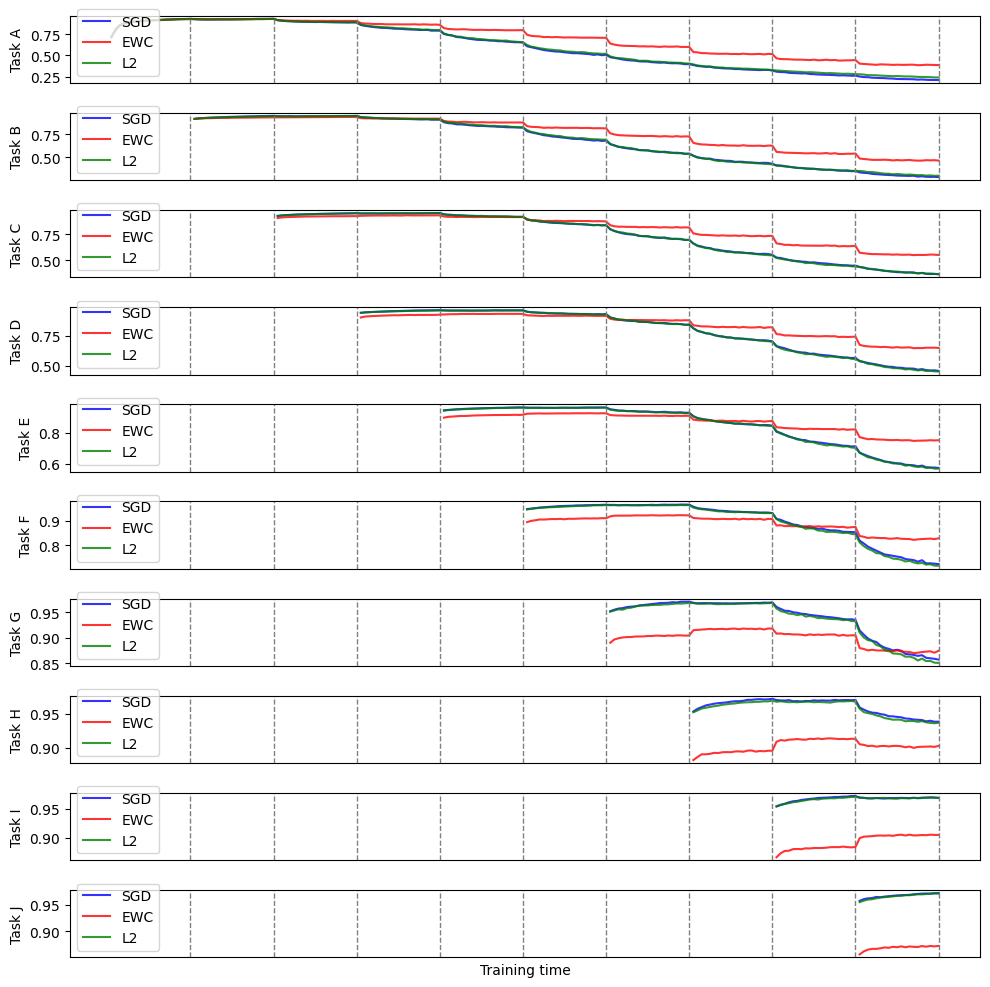

In [5]:
#Plot results for experiment 2A on rotated MNIST
file_path = "experiment2A_results_rotated.csv"
df = pd.read_csv(file_path)

tasks = sorted(df['Train_Task'].unique())

epoch_accuracies_SGD_rotated = {task: [] for task in tasks}
epoch_accuracies_EWC_rotated = {task: [] for task in tasks}
epoch_accuracies_L2_rotated = {task: [] for task in tasks}

for task in tasks:
    for val_task in tasks:
        subset = df[(df['Train_Task'] == task) & (df['Eval_Task'] == val_task)]
        
        epoch_accuracies_SGD_rotated[task].append(list(subset['SGD_Accuracy']))
        epoch_accuracies_EWC_rotated[task].append(list(subset['EWC_Accuracy']))
        epoch_accuracies_L2_rotated[task].append(list(subset['L2_Accuracy']))
plot_experiment_2A(epoch_accuracies_SGD_rotated, epoch_accuracies_EWC_rotated, epoch_accuracies_L2_rotated)

In [3]:
#Run experiment 2B on permutated MNIST 
num_tasks_permuted_2B = 10
acc_sgd_permuted, acc_ewc_permuted = run_experiment_2B(permuted_train_loaders[0:num_tasks_permuted_2B],permuted_test_loaders[0:num_tasks_permuted_2B])

Trial 1/10: Learning rate=0.00005, Hidden layer width=445
Training on Task 1
Task 1, Epoch 1/20, SGD Loss: 0.0031
Task 1, Epoch 1/20, EWC Loss: 0.0030
Task 1, Epoch 2/20, SGD Loss: 0.0031
Task 1, Epoch 2/20, EWC Loss: 0.0030
Task 1, Epoch 3/20, SGD Loss: 0.0030
Task 1, Epoch 3/20, EWC Loss: 0.0030
Task 1, Epoch 4/20, SGD Loss: 0.0030
Task 1, Epoch 4/20, EWC Loss: 0.0031
Task 1, Epoch 5/20, SGD Loss: 0.0030
Task 1, Epoch 5/20, EWC Loss: 0.0030
Task 1, Epoch 6/20, SGD Loss: 0.0030
Task 1, Epoch 6/20, EWC Loss: 0.0030
Task 1, Epoch 7/20, SGD Loss: 0.0030
Task 1, Epoch 7/20, EWC Loss: 0.0030
Task 1, Epoch 8/20, SGD Loss: 0.0030
Task 1, Epoch 8/20, EWC Loss: 0.0029
Task 1, Epoch 9/20, SGD Loss: 0.0029
Task 1, Epoch 9/20, EWC Loss: 0.0029
Task 1, Epoch 10/20, SGD Loss: 0.0029
Task 1, Epoch 10/20, EWC Loss: 0.0029
Task 1, Epoch 11/20, SGD Loss: 0.0029
Task 1, Epoch 11/20, EWC Loss: 0.0029
Task 1, Epoch 12/20, SGD Loss: 0.0029
Task 1, Epoch 12/20, EWC Loss: 0.0029
Task 1, Epoch 13/20, SGD Loss

KeyboardInterrupt: 

In [ ]:
#Plot results for experiment 2B on permutated MNIST

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_tasks_permuted_2B + 1), acc_sgd_permuted, label='SGD+dropout', marker='o', color='blue')
plt.plot(range(1, num_tasks_permuted_2B + 1), acc_ewc_permuted, label='EWC', marker='o', color='red')
plt.axhline(y=1.0, linestyle='--', color='black', label='Single Task Performance')
plt.xlabel('Number of Tasks')
plt.ylabel('Fraction Correct')
plt.legend()
plt.title('Fraction Correct vs Number of Tasks')
plt.grid(True)
plt.show()

In [ ]:
#Save results for results of experiment 2B on permuted dataset

results_permuted_2B = pd.DataFrame({
    'Task': [f'Task {i+1}' for i in range(len(acc_sgd_permuted))],
    'SGD Accuracy': acc_sgd_permuted,
    'EWC Accuracy': acc_ewc_permuted
})

# Save the DataFrame to a CSV file
results_permuted_2B.to_csv('experiment2B_results_permuted.csv', index=False)

print("Results saved to experiment2B_results_permuted.csv")

In [ ]:
#Run experiment 2B on rotated MNIST 
num_tasks_rotated_2B = 3
acc_sgd_rotated, acc_ewc_rotated = run_experiment_2B(rotated_train_loaders[0:num_tasks_rotated_2B],rotated_test_loaders[0:num_tasks_rotated_2B])

In [ ]:
#Plot results for experiment 2B on rotated MNIST

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_tasks_rotated_2B + 1), acc_sgd_rotated, label='SGD+dropout', marker='o', color='blue')
plt.plot(range(1, num_tasks_rotated_2B + 1), acc_ewc_rotated, label='EWC', marker='o', color='red')
plt.axhline(y=1.0, linestyle='--', color='black', label='Single Task Performance')
plt.xlabel('Number of Tasks')
plt.ylabel('Fraction Correct')
plt.legend()
plt.title('Fraction Correct vs Number of Tasks')
plt.grid(True)
plt.show()

In [ ]:
#Save results for results of experiment 2B on rotated dataset

results_rotated_2B = pd.DataFrame({
    'Task': [f'Task {i+1}' for i in range(len(acc_sgd_rotated))],
    'SGD Accuracy': acc_sgd_rotated,
    'EWC Accuracy': acc_ewc_rotated
})

# Save the DataFrame to a CSV file
results_rotated_2B.to_csv('experiment2B_results_rotated.csv', index=False)

print("Results saved to experiment2B_results_rotated.csv")